In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Importar nuestro archivo de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append('../..') #pongo los 2 puntos para que salga de la carpeta
from src import soporte_clustering as sc
from src import funciones as f
from src import soporte_prep as spp
from src import soporte_encoding as se

import warnings
warnings.filterwarnings('ignore')
import math

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../../Datos/df_predecir_1.csv', index_col=0)

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,cluster
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,1
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,1
2,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,1
3,31192,IN-2012-86369,14-04-2012,18-04-2012,Standard Class,MB-18085,Mick Brown,Consumer,Hamilton,Waikato,New Zealand,NaN,APAC,Oceania,FUR-TA-10002958,Furniture,Tables,"Chromcraft Conference Table, Fully Assembled",5244.840,6,0.0,996.4800,878.38,High,1
4,34577,CA-2011-102988,05-04-2011,09-04-2011,Second Class,GM-14695,Greg Maxwell,Corporate,Alexandria,Virginia,United States,22304.0,US,South,OFF-SU-10002881,Office Supplies,Supplies,Martin Yale Chadless Opener Electric Letter Op...,4164.050,5,0.0,83.2810,846.54,High,1


In [4]:
df.drop(columns=['State', 'Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'City', 'Postal Code','Product ID', 'Product Name', 'Profit', 'cluster', 'Customer Name', 'Country', 'Region'], inplace=True)

In [5]:
df.head()

,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Quantity,Discount,Shipping Cost,Order Priority
0,Same Day,Consumer,US,Technology,Accessories,2309.650,7,0.0,933.57,Critical
1,Second Class,Corporate,APAC,Furniture,Chairs,3709.395,9,0.1,923.63,Critical
2,Same Day,Consumer,Africa,Technology,Copiers,2832.960,8,0.0,903.04,Critical
3,Standard Class,Consumer,APAC,Furniture,Tables,5244.840,6,0.0,878.38,High
4,Second Class,Corporate,US,Office Supplies,Supplies,4164.050,5,0.0,846.54,High


In [6]:
f.exploracion_dataframe(df, 'Sales')

El número de datos es 30723 y el de columnas es 10

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 6

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Ship Mode,object
Segment,object
Market,object
Category,object
Sub-Category,object
Sales,float64
Quantity,int64
Discount,float64
Shipping Cost,float64
Order Priority,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna Ship Mode tiene los siguientes valores únicos:


,count
Ship Mode,
Standard Class,18416
Second Class,6292
First Class,4411
Same Day,1604


La columna Segment tiene los siguientes valores únicos:


,count
Segment,
Consumer,15626
Corporate,9211
Home Office,5886


La columna Market tiene los siguientes valores únicos:


,count
Market,
APAC,6381
LATAM,6241
US,6020
EU,5886
EMEA,3227
Africa,2728
Canada,240


La columna Category tiene los siguientes valores únicos:


,count
Category,
Office Supplies,18980
Technology,5940
Furniture,5803


La columna Sub-Category tiene los siguientes valores únicos:


,count
Sub-Category,
Binders,3775
Art,3024
Storage,2997
Paper,2170
Chairs,1997
Phones,1962
Furnishings,1922
Accessories,1850
Labels,1613


La columna Order Priority tiene los siguientes valores únicos:


,count
Order Priority,
Medium,17699
High,9357
Critical,2308
Low,1359


In [7]:
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

df['Discount_Category'] = pd.cut(
    df['Discount'],
    bins=[-float('inf'), 0.250, 0.500, 0.750, float('inf')],  # Límites de las categorías
    labels=['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']  # Nombres de las categorías
)

df['Quantity_Group'] = pd.cut(
    df['Quantity'],
    bins=[-float('inf'), 5, 10, 15],  # Límites de los grupos
    labels=['<= 5', '6 - 10', '11 - 15']  # Nombres de los grupos
)

df.drop(columns=['Quantity', 'Discount'], inplace=True)

Convierto estas 2 columnas numéricas a categóricas porque sus valores no son tan grandes, además de que son específicos.

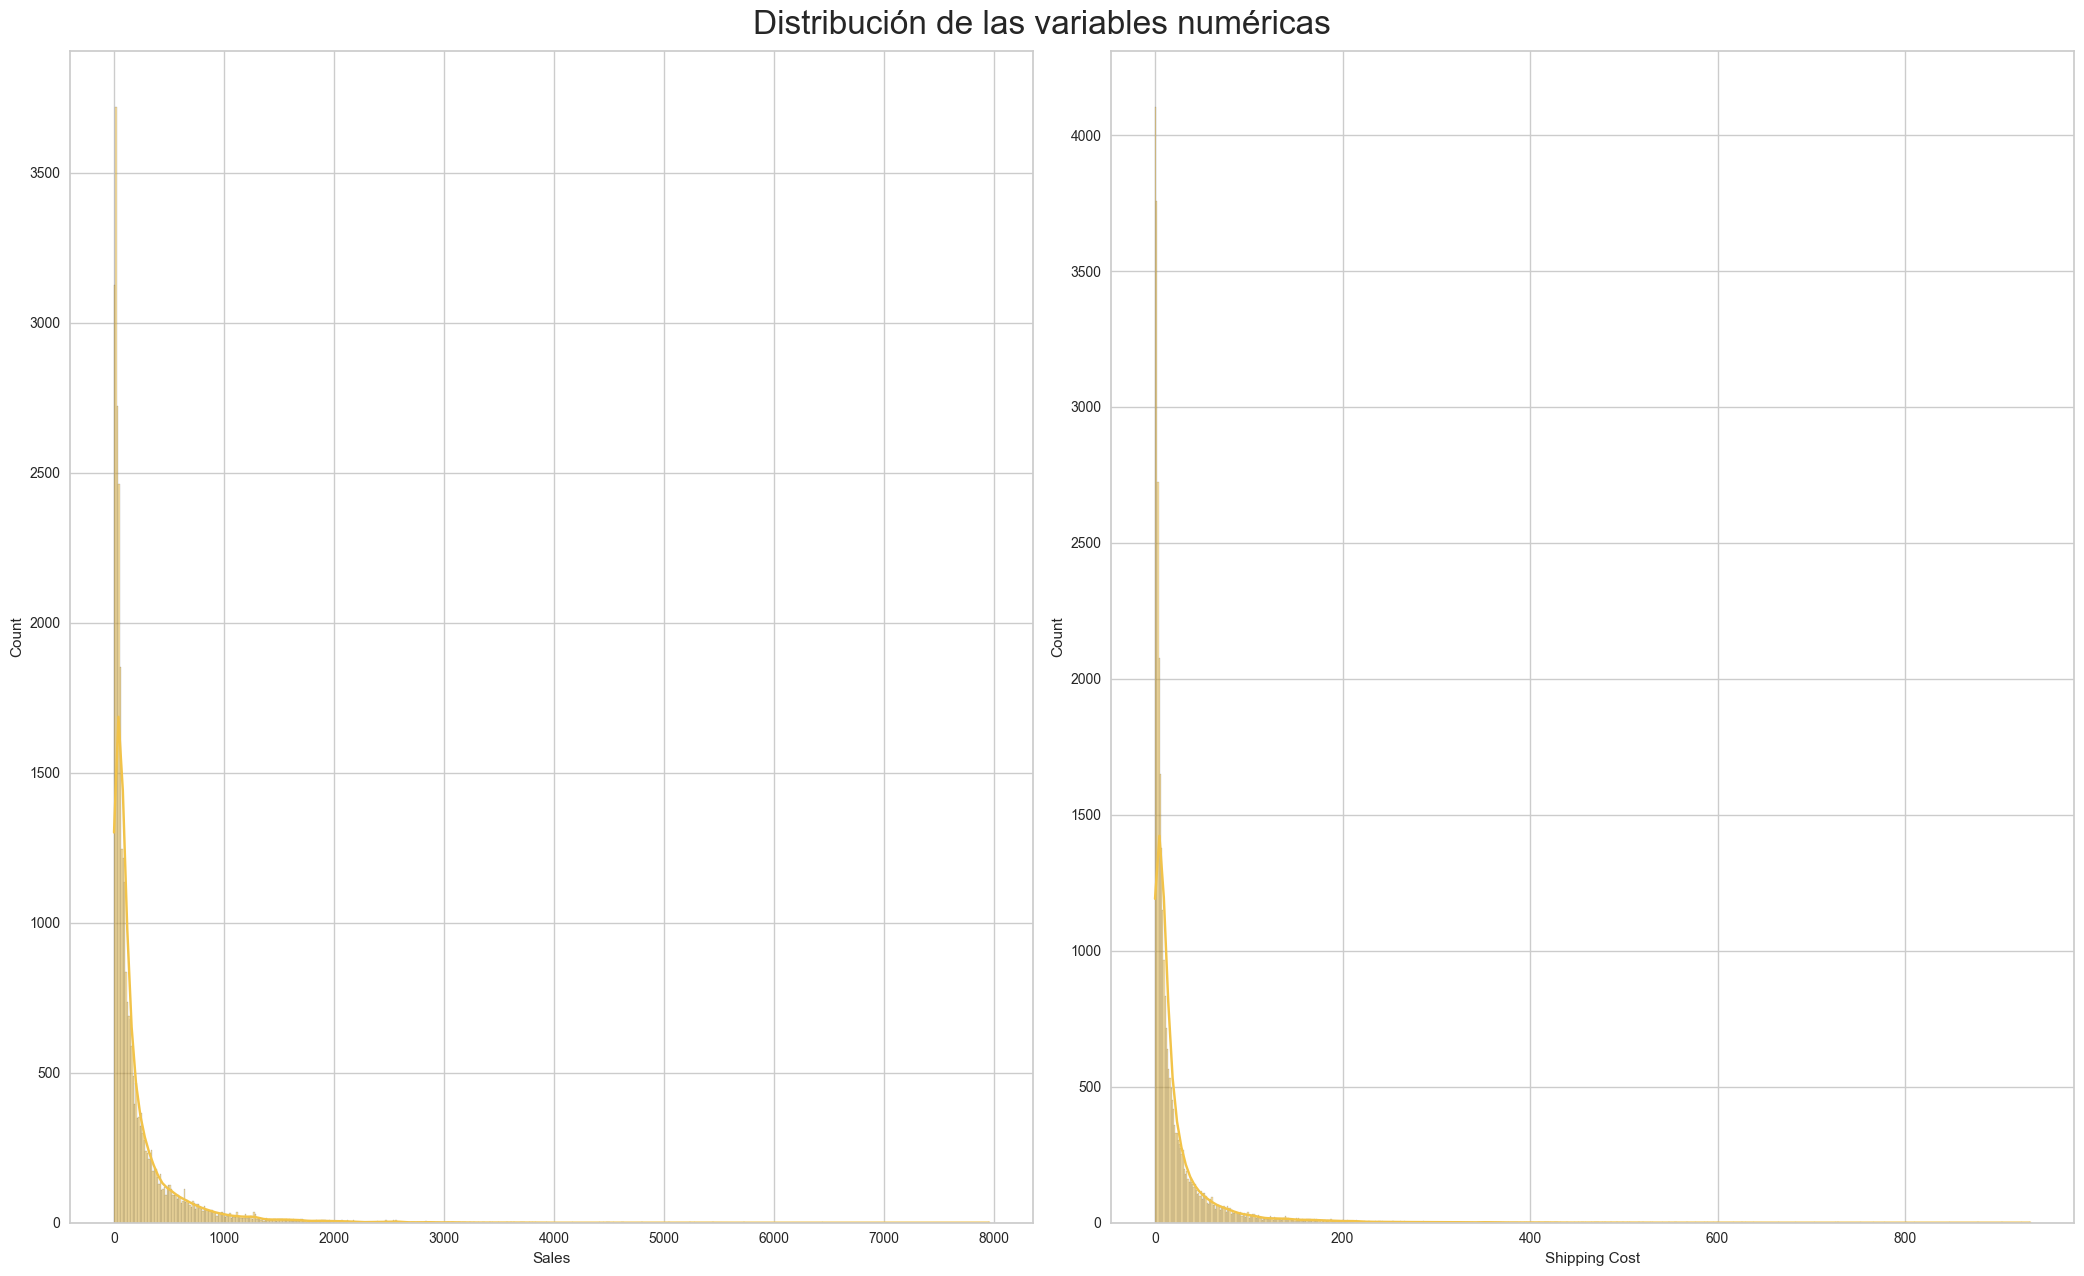

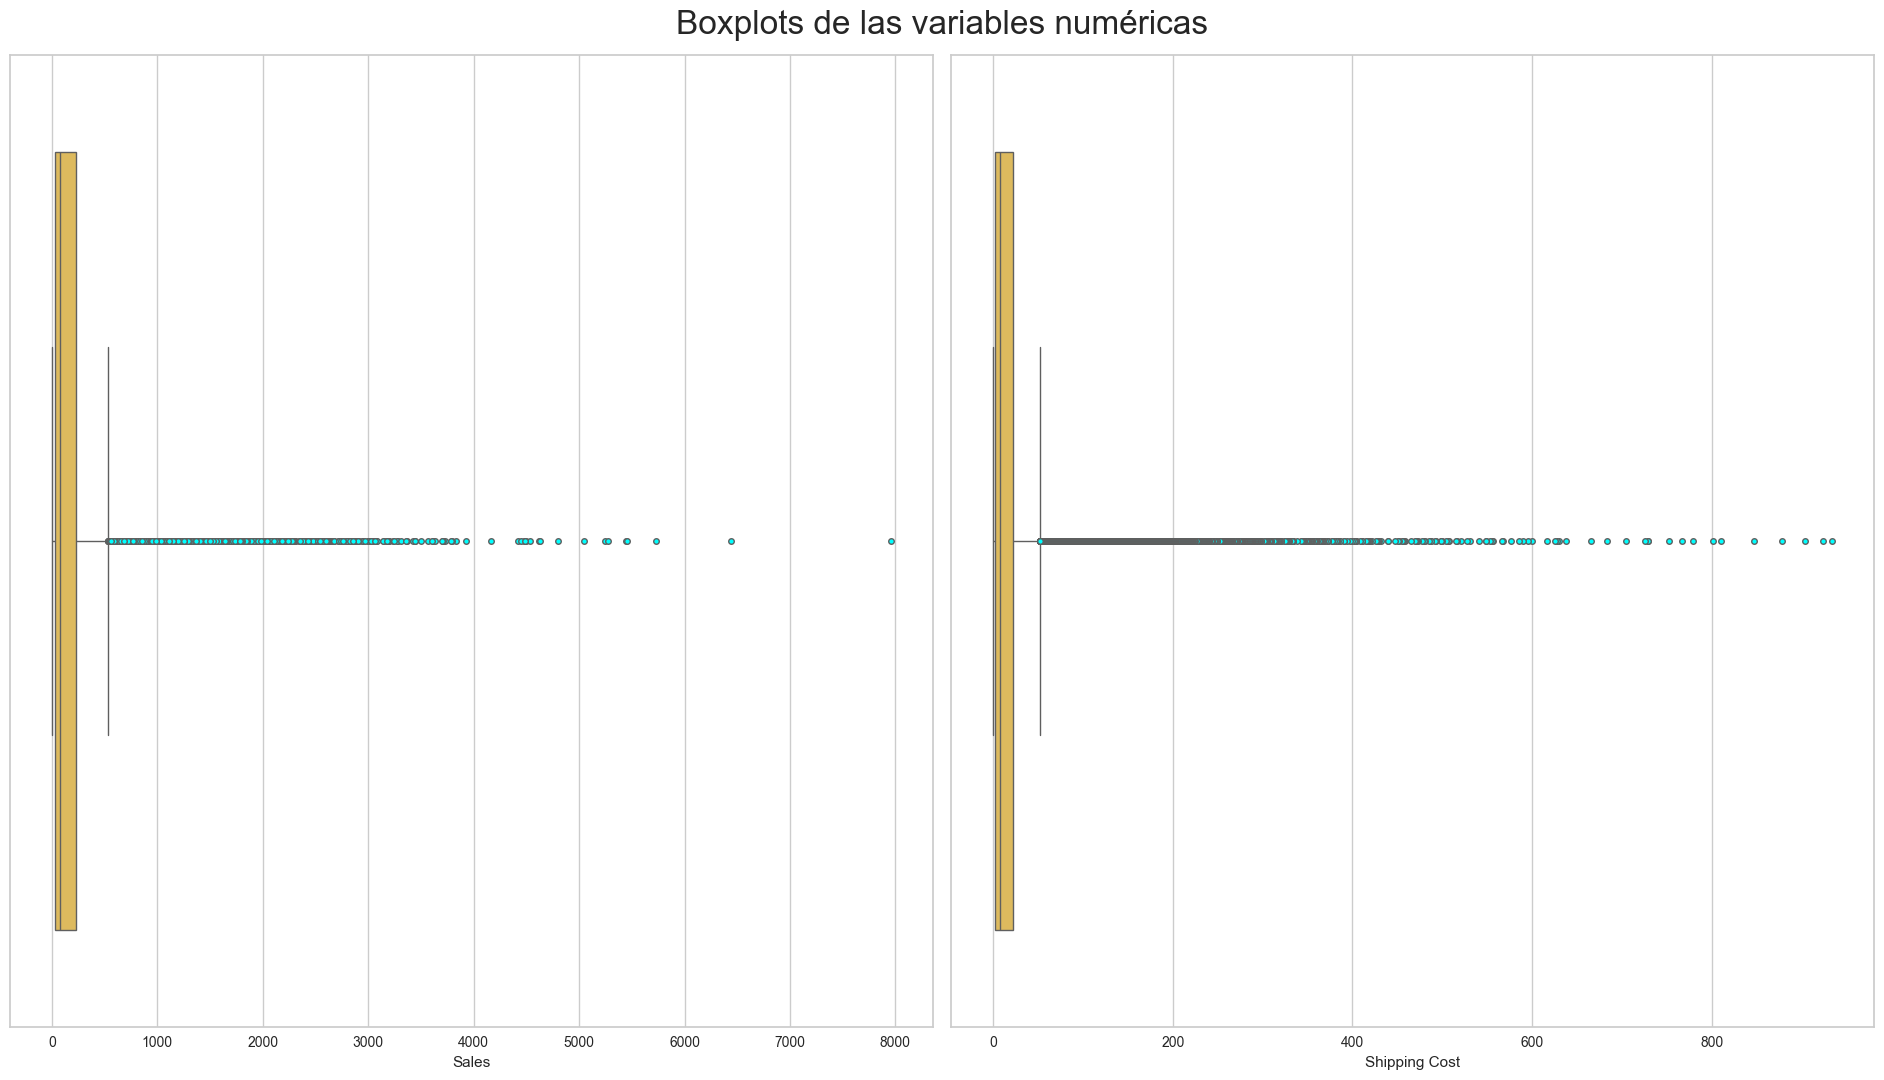

In [8]:
preprocesar_cluster = sc.Exploracion(df)
preprocesar_cluster.visualizar_numericas()

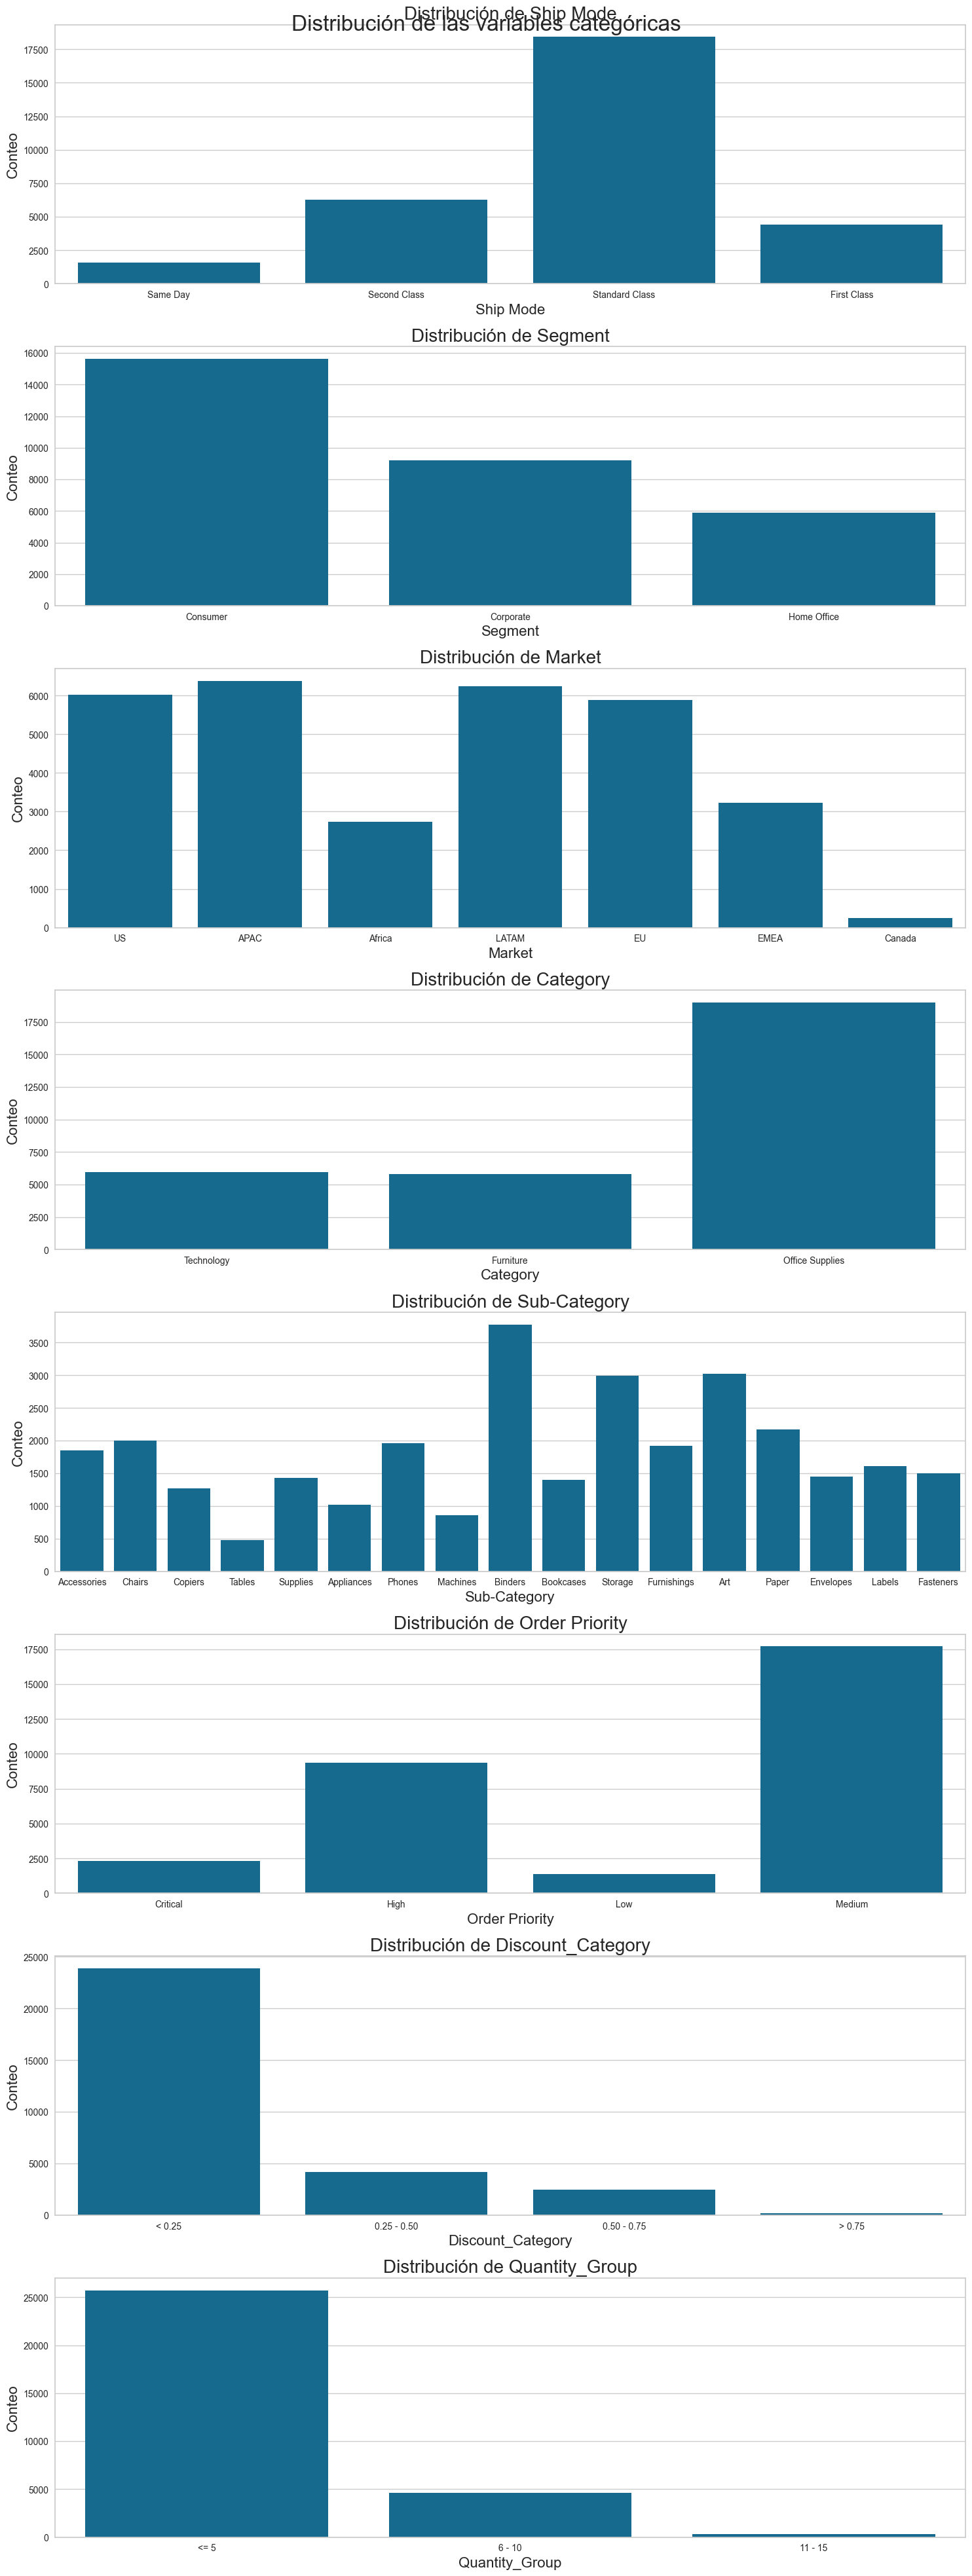

In [9]:
preprocesar_cluster.visualizar_categoricas()

Observaciones:
- Para Ship Mode, standar es la más frecuente.
- Para Segment, Consumer tiene una amplia dominancia sobre las demás categorías.
- Para Market, APAC es quien domina pero seguida de cerca por LATAM.
- Para Category, office suplies es quien domina ampliamente sobre las otras.
- Para Sub-Category, Binders es la que más domina. Tiene 2 categorías que le siguen, aunque no tan cerca. Con respecto a las demás, la diferencia es bastante notoria.
- Para Order Priority, Medium es la de mayor frecuencia.
- Discount_Category, posee la mayor presencia de todas en el margen de 0-0.25%
- Quantity_Group, el grupo de menos de 5 artículos es el de mayor presencia.

## Estandarizar 

In [10]:
lista_num = df.select_dtypes(include=['int64', 'float64']).columns.tolist() # saco mis columnas numéricas

if 'Sales' in lista_num:
    lista_num.remove('Sales')

In [11]:
f.escalar_columnas_metodo(df, lista_num, 'robust')

,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Shipping Cost,Order Priority,Discount_Category,Quantity_Group
0,Same Day,Consumer,US,Technology,Accessories,2309.650,46.172483,Critical,< 0.25,6 - 10
1,Second Class,Corporate,APAC,Furniture,Chairs,3709.395,45.676969,Critical,< 0.25,6 - 10
2,Same Day,Consumer,Africa,Technology,Copiers,2832.960,44.650548,Critical,< 0.25,6 - 10
3,Standard Class,Consumer,APAC,Furniture,Tables,5244.840,43.421236,High,< 0.25,6 - 10
4,Second Class,Corporate,US,Office Supplies,Supplies,4164.050,41.833998,High,< 0.25,<= 5
...,...,...,...,...,...,...,...,...,...,...
30718,Standard Class,Corporate,US,Office Supplies,Appliances,1.624,-0.365404,Medium,> 0.75,<= 5
30719,First Class,Consumer,LATAM,Office Supplies,Paper,84.000,-0.365404,High,< 0.25,<= 5
30720,Standard Class,Home Office,APAC,Office Supplies,Binders,58.050,-0.365902,Medium,< 0.25,<= 5
30721,Same Day,Corporate,APAC,Office Supplies,Fasteners,65.100,-0.365902,Medium,< 0.25,<= 5


In [12]:
lista_col_cat = df.select_dtypes(include=['object', 'category'])

In [13]:
asunciones = se.Asunciones(dataframe=df, columna_numerica='Sales')

for categoria in lista_col_cat:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = se.TestEstadisticos(df, "Sales", categoria)
    test.run_all_tests()
    print("\n###########################\n")

Estamos analizando la variable SHIP MODE
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Ship Mode las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Same Day', 'Second Class', 'Standard Class', 'First Class']

Realizando test de Kruskal...
Estadístico de prueba: 1.532218929697752
Valor p: 0.6748544293065264
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,18.4127,0.3445,-10.0654,46.8909,First Class-Same Day
1,10.1048,0.5287,-9.0755,29.2850,First Class-Second Class
2,6.9057,0.6996,-9.4670,23.2785,First Class-Standard Class
3,-8.3080,0.8630,-35.6274,19.0115,Same Day-Second Class
4,-11.5070,0.6505,-36.9341,13.9201,Same Day-Standard Class
5,-3.1990,0.9392,-17.4614,11.0633,Second Class-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Corporate', 'Home Office']

Realizando test de Kruskal...
Estadístico de prueba: 0.14747783632290207
Valor p: 0.9289141848081399
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-1.4871,0.9523,-13.1922,10.2179,Consumer-Corporate
1,6.0605,0.5501,-7.5667,19.6877,Consumer-Home Office
2,7.5476,0.4593,-7.3214,22.4166,Corporate-Home Office



###########################

Estamos analizando la variable MARKET
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Market las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['US', 'APAC', 'Africa', 'LATAM', 'EU', 'EMEA', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 1716.3789862025735
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-121.5602,0.0000,-146.9785,-96.1419,APAC-Africa
1,-128.8774,0.0000,-201.9391,-55.8157,APAC-Canada
2,-139.3626,0.0000,-163.3647,-115.3604,APAC-EMEA
3,-10.4308,0.7258,-30.5121,9.6506,APAC-EU
4,-77.9787,0.0000,-97.7607,-58.1967,APAC-LATAM
5,-93.6727,0.0000,-113.6374,-73.7080,APAC-US
6,-7.3172,1.0000,-82.1310,67.4967,Africa-Canada
7,-17.8024,0.5369,-46.7023,11.0976,Africa-EMEA
8,111.1295,0.0000,85.3930,136.8659,Africa-EU
9,43.5815,0.0000,18.0780,69.0851,Africa-LATAM



###########################

Estamos analizando la variable CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Technology', 'Furniture', 'Office Supplies']

Realizando test de Kruskal...
Estadístico de prueba: 8581.314221135679
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-263.6727,0.0,-276.1438,-251.2016,Furniture-Office Supplies
1,33.6318,0.0,18.2865,48.9770,Furniture-Technology
2,297.3045,0.0,284.9440,309.6649,Office Supplies-Technology



###########################

Estamos analizando la variable SUB-CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Sub-Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Accessories', 'Chairs', 'Copiers', 'Tables', 'Supplies', 'Appliances', 'Phones', 'Machines', 'Binders', 'Bookcases', 'Storage', 'Furnishings', 'Art', 'Paper', 'Envelopes', 'Labels', 'Fasteners']

Realizando test de Kruskal...
Estadístico de prueba: 14495.277810513775
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,261.9451,0.0,217.7786,306.1117,Accessories-Appliances
1,-146.2313,0.0,-179.6377,-112.8249,Accessories-Art
2,-158.5130,0.0,-190.6334,-126.3927,Accessories-Binders
3,347.3106,0.0,307.2513,387.3699,Accessories-Bookcases
4,166.7007,0.0,130.1791,203.2223,Accessories-Chairs
...,...,...,...,...,...
131,-346.8277,0.0,-386.1645,-307.4910,Phones-Supplies
132,312.0549,0.0,254.4225,369.6872,Phones-Tables
133,-120.1018,0.0,-156.4600,-83.7437,Storage-Supplies
134,538.7807,0.0,483.1388,594.4227,Storage-Tables



###########################

Estamos analizando la variable ORDER PRIORITY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Order Priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Critical', 'High', 'Low', 'Medium']

Realizando test de Kruskal...
Estadístico de prueba: 2.2209055885349125
Valor p: 0.527842369324178
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-10.0812,0.6641,-32.7814,12.6191,Critical-High
1,-12.8332,0.7567,-46.2298,20.5634,Critical-Low
2,-11.5569,0.5160,-33.1728,10.0590,Critical-Medium
3,-2.7521,0.9946,-31.1060,25.6018,High-Low
4,-1.4757,0.9903,-13.9600,11.0086,High-Medium
5,1.2764,0.9994,-26.2171,28.7698,Low-Medium



###########################

Estamos analizando la variable DISCOUNT_CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Discount_Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']

Realizando test de Kruskal...
Estadístico de prueba: 1573.4528041879555
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-98.5660,0.0000,-123.1863,-73.9458,0.25 - 0.50-0.50 - 0.75
1,51.8601,0.0000,35.5906,68.1296,0.25 - 0.50-< 0.25
2,-111.3041,0.0002,-181.0292,-41.5790,0.25 - 0.50-> 0.75
3,150.4261,0.0000,129.9245,170.9277,0.50 - 0.75-< 0.25
4,-12.7381,0.9673,-83.5703,58.0942,0.50 - 0.75-> 0.75
5,-163.1642,0.0000,-231.5436,-94.7847,< 0.25-> 0.75



###########################

Estamos analizando la variable QUANTITY_GROUP
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Quantity_Group las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['6 - 10', '<= 5', '11 - 15']

Realizando test de Kruskal...
Estadístico de prueba: 2273.450141494283
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-190.3558,0.0,-238.2983,-142.4134,11 - 15-6 - 10
1,-434.9696,0.0,-481.5280,-388.4111,11 - 15-<= 5
2,-244.6137,0.0,-258.3429,-230.8846,6 - 10-<= 5



###########################



- Resultados:
    - Ship Mode: no tiene orden
    - Segment: no tiene orden.
    - Market : tiene orden
    - Category: tiene orden.
    - Sub-Category: tiene orden
    - Order Priotity: no tiene orden.
    - Discount Category: tiene orden.
    - Quantity Group: tiene orden.

In [17]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment', 'Order Priority'], # no metemos ninguna columna porque todas nuestras columnas tienen orden
                        "dummies": [], # no metemos ninguna columna porque todas tienen orden
                        'ordinal' : {},
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["Market", "Category", "Sub-Category", "Discount_Category", "Quantity_Group"]
                        }

In [18]:
encoding = se.Encoding(df, diccionario_encoding, "Sales")
df_encode = encoding.one_hot_encoding()
df_encode = encoding.target_encoding()
df_encode.head()

,Ship Mode,Segment,Sales,Shipping Cost,Order Priority,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,Same Day,Consumer,2309.650,46.172483,Critical,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,184.746760,406.920476,221.649278,238.638826,417.991151
1,Second Class,Corporate,3709.395,45.676969,Critical,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,280.765352,376.156674,395.652475,238.638826,417.991151
2,Same Day,Consumer,2832.960,44.650548,Critical,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,153.708483,400.579782,601.838328,235.582284,418.867386
3,Standard Class,Consumer,5244.840,43.421236,High,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,279.150012,372.352737,723.616049,235.582284,418.867386
4,Second Class,Corporate,4164.050,41.833998,High,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,183.527906,109.485297,90.500003,235.582284,173.453124


In [19]:
df_encode.drop(columns=['Ship Mode', 'Segment', 'Order Priority'], inplace=True)

In [20]:
df_encode.shape

(30723, 18)

In [21]:
df_encode.to_csv('../../Datos/Datos_Modelo_1/Modelo_1_CL_1.csv')